# Computing Conway's Game of Life
## A machine learning and computer vision approach

<img style="width:400px" src="https://upload.wikimedia.org/wikipedia/commons/e/e5/Gospers_glider_gun.gif">

## So What are the rules?

### Living Cells: 
* **Overpopulation**: if a living cell is surrounded by more than three living cells, it dies.

* **Stasis**: if a living cell is surrounded by two or three living cells, it survives.

* **Underpopulation**: if a living cell is surrounded by fewer than two living cells, it dies.

### Dead Cells
* **Reproduction**: if a dead cell is surrounded by exactly three cells, it becomes a live cell.




### These rules can be simplified by the following:

cell has 3 living neighbors -> alive

cell has 2 living neighbors and is alive -> alive

otherwise -> dead

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import scipy
import scipy.sparse

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
root = '/kaggle/input/conways-reverse-game-of-life-2020'

train_df = pd.read_csv(root + '/train.csv')
test_df = pd.read_csv(root + '/test.csv')
sample_df = pd.read_csv(root + '/sample_submission.csv')

In [ ]:
train_df.head()

In [ ]:
train_df.info()

In [ ]:
start = [col for col in train_df.columns if 'start' in col]
stop  = [col for col in train_df.columns if 'stop' in col]

def plot_game(idx):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,3), dpi=200)
    ax1.imshow(train_df.loc[idx,start].values.reshape(25,25))
    ax2.imshow(train_df.loc[idx,stop].values.reshape(25,25))

    fig.suptitle('Delta: {}'.format(train_df.loc[idx, "delta"]))

    ax1.set_title('Start')
    ax2.set_title('Stop')

    ax1.set_xticks([0,5,10,15,20]);
    ax1.set_yticks([0,5,10,15,20]);
    ax2.set_xticks([0,5,10,15,20]);
    ax2.set_yticks([0,5,10,15,20]);

In [ ]:
plot_game(4)

In [ ]:
plot_game(3)

# Strategy

## 1) Understand the problem. 
 - Consider computational and functional limitations.
 - How is this different from standarm ML problem statements?

## 2) Solve/Model the "Forward" problem.
- We can easily compute the state of conway's game at time t+1 given the state at time t.
- It should be feasible to train an ML model to find that function too right?

## 3) Solve/Model the "Reverse" Problem.
- There are many approaces to take. 
- It's likely that an optimized brute force or hard coded model would do the best. (100% accuracy is possible)
- These methods are difficult to implement and this is a project for a Data Mining class after all.
- Instead let's exploit the local precision of Convolutional neural nets to find a nice local minimimum. 

Conway's game of life is built from a few deceptively simple rules which lead to immense complexity. 

# 1) Understanding the Problem


## What is the general machine learning problem?

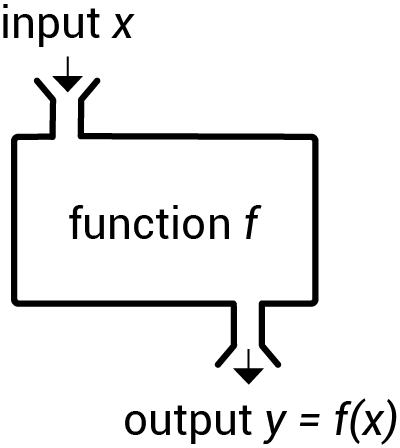

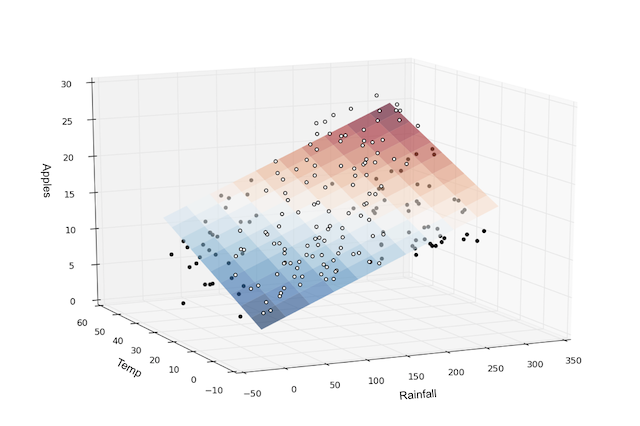

# Neural Network 

<img style="width:400px" src="https://miro.medium.com/max/1804/1*f9XlMlruW7TMF3EHbPDfYg.png">

# We hope there is a particular function underlying the relationship

---------------------------------------------


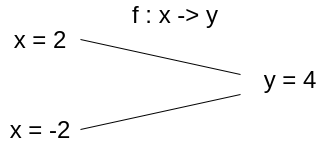

# 2) The "Forward" problem.

# Dataset Configuration

## Data Genereration

Rather than simply training on the dataset provided by kaggle, we can improve the learning rate by generating more board states.


In [ ]:
# Credit: This was inspired by 's getting started notebook

def update_cell(board,i,j):
    neighbors = sum(board[k % len(board)][l % len(board)] 
                        for k in range(i-1,i+2)
                            for l in range(j-1,j+2)
                                if k != i or l != j)
    return 1 if neighbors == 3 or (neighbors == 2 and board[i][j]) else 0

def step_forward(board):
    return np.array([np.array([update_cell(board,i,j) for j in range(len(board))]) 
                                                         for i in range(len(board))])

# Sanity Check

## step_forward function should update board in accordance w/ data set

In [ ]:
idx = 40

d = train_df.iloc[idx,1]
start = train_df.iloc[idx,2:627].values.reshape(25,25)
stop = train_df.iloc[idx,627:].values.reshape(25,25)

print('delta = {}'.format(d))
plt.figure(figsize=(5,4), dpi=140)
plt.imshow(start)

In [ ]:
pred = start

for _ in range(d):
    pred = step_forward(pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,5), dpi=140)
ax1.set_title('kaggle dataset')
ax2.set_title('step_forward')
ax1.imshow(stop)
ax2.imshow(pred)

In [ ]:
def generate_game(delta=1):
    density = np.random.random() * 0.98 + 0.01
    start   = scipy.sparse.random(25, 25, density=density, data_rvs=np.ones).toarray()
    stop    = start
    
    for _ in range(delta):
        stop = step_forward(stop)
        
    if np.count_nonzero(start) == 0: return generate_game()
    if np.count_nonzero(stop) == 0: return generate_game()
    
    return delta,start,stop

def generate_games(n=10000,delta=1):
    games = []
    for i in range(n):
        if (i + 1) % 1000 == 0: print('{} games created'.format(i+1))
        games.append(generate_game(delta))
    return games 

In [ ]:
games = generate_games()

# Pytorch

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset, random_split

## CglDataset: custom dataset class

In [ ]:
class CglDataset(Dataset):
    def __init__(self, data=[], transform=None):
        self.data = data[:]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, n):
        delta,start,stop = self.data[n]
        if self.transform:
            stop  = self.transform(stop).float()
            start = self.transform(start).float()
        return (delta, start, stop)
    
    def loadFromDataFrame(self, df):
        for i in range(len(df)):
            data = df.iloc[i]
            delta = data[1]
            start = data[2:627].values.reshape((25,25)).astype(np.float32)
            stop = data[627:].values.reshape((25,25)).astype(np.float32)
            self.data.append((delta, start, stop))

In [ ]:
train_ds = CglDataset(games, transform=ToTensor())
#delta, start, stop = train_ds[3]
#print(delta)

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,5), dpi=140)
#ax1.set_title('start')
#ax2.set_title('stop')
#ax1.imshow(start[0,:,:])
#ax2.imshow(stop[0,:,:])

In [ ]:
print(len(train_ds))
delta_one = train_df[train_df['delta'] == 1]
train_ds.loadFromDataFrame(delta_one)
print(len(train_ds))

## Split into separate train and validation sets

In [ ]:
train_ds, val_ds = random_split(train_ds, [15000, 5113])
len(train_ds), len(val_ds)

In [ ]:
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [ ]:
for delta, start, stop in train_loader:
    print(stop.shape)
    print(start.shape)
    break

# Solving forward problem with Deep Learning

## Feed Forward NN: CGL Neural Network class 
hidden layers: 2

# Loss Function

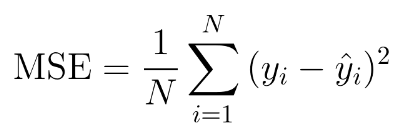

In [ ]:
class CglNNet(nn.Module):
    def __init__(self, l1_size, l2_size):
        super().__init__()
        self.fc1 = nn.Linear(625, l1_size)
        self.fc2 = nn.Linear(l1_size, l2_size)
        self.fc3 = nn.Linear(l2_size, 625)
        
    def forward(self, x):
        x = x.reshape(-1, 625)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
        
    
    @torch.no_grad()
    def evaluate(self, loader, loss_fn):
        loss, accur = [], []
        for delta, start, stop in loader:
            out = self(start)
            target = stop.reshape(-1, 625)
            loss.append(loss_fn(out, target))
            accur.append(self.accuracy(out, target))
        mean_loss  = torch.stack(loss).mean()
        mean_accur = torch.stack(accur).mean()
        return mean_loss, mean_accur
    
    def accuracy(self, outputs, expected):
        res = torch.sum(self.cast_int(outputs) == self.cast_int(expected)).cpu().numpy() / np.prod(outputs.shape)
        return torch.tensor(res)
    
    def cast_int(self, num):
        return self.cast_bool(num).to(torch.int8)
    
    def cast_bool(self, x):
        return (x > 0.5)
    
    @staticmethod
    def weights_init(layer):
        if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(layer.weight)
            nn.init.constant_(layer.bias, 0.1)


# GPU config

In [ ]:
torch.cuda.is_available()

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
    
device = get_default_device()
device

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
layer1 = 1024
layer2 = 512

# Neural Net
model = CglNNet(layer1, layer2)
to_device(model, device)

In [ ]:
print(model.fc1.weight.shape, model.fc1.bias.shape)
print(model.fc2.weight.shape, model.fc2.bias.shape)
print(model.fc3.weight.shape, model.fc3.bias.shape)

model.fc1.weight

In [ ]:
def nn_fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD, loss_fn=nn.MSELoss()):
    
    optimizer = opt_func(model.parameters(), lr)
    history = []
    
    for e in range(epochs):
        
        # Training Phase 
        for delta, start, stop in train_loader:
            out = model(start)
            loss = loss_fn(out, stop.reshape(-1, 625))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        val_loss, val_accur = model.evaluate(val_loader, loss_fn)
        print('Epoch [{} / {}], Validation Loss: {}, Validation Accuracy: {}'.format(e+1, epochs, val_loss, val_accur))
        history.append((val_loss, val_accur))

    return history

In [ ]:
history = nn_fit(20, .05, model, train_loader, val_loader)

## Convolutional Neural Network: CGL CNN class 

### Layers
1) 2D Convolution with 9 Channel(s): kernel_size = 3, padding = 1, out = (9,n,25,25)

2) ReLU Activation function to introduce non-linearity

3) 2D Convolution with 1 Channel(s): kernel_size = 1, padding = 0, out = (1,n,25,25)

4) Sigmoid function to compress outputs into (0,1) interval

In [ ]:
class CglCNN(nn.Module):
    def __init__(self):
        super().__init__() 

        self.conv1   = nn.Conv2d(1, 9, kernel_size=(3,3), padding=1, padding_mode='circular') #padding_mode='circular'
        self.conv2   = nn.Conv2d(9, 1,  kernel_size=(1,1))
        self.apply(self.weights_init)


    def forward(self, x):
        x = self.cast_inputs(x)

        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = torch.sigmoid(x)
        
        return x
    
    @torch.no_grad()
    def evaluate(self, loader, loss_fn):
        loss, accur = [], []
        for delta, start, stop in loader:
            out = self(start)
            target = stop
            loss.append(loss_fn(out, target))
            accur.append(self.accuracy(out, target))
        mean_loss  = torch.stack(loss).mean()
        mean_accur = torch.stack(accur).mean()
        return mean_loss, mean_accur
    
    def accuracy(self, outputs, expected):
        res = torch.sum(self.cast_int(outputs) == self.cast_int(expected)).cpu().numpy() / np.prod(outputs.shape)
        return torch.tensor(res)
    
    def cast_int(self, num):
        return self.cast_bool(num).to(torch.int8)
    
    def cast_bool(self, x):
        return (x > 0.5)
    
    @staticmethod
    def weights_init(layer):
        if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(layer.weight)
            nn.init.constant_(layer.bias, 0.1)
            
    def cast_to_tensor(self, x):
        if torch.is_tensor(x):
            return x.to(torch.float32).to(device)
        if isinstance(x, list):
            x = np.array(x)
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).to(torch.float32)
            x = x.to(device)
            return x  # x.shape = (42,3)
        raise TypeError(f'{self.__class__.__name__}.cast_to_tensor() invalid type(x) = {type(x)}')


    # Credit: 
    def cast_inputs(self, x):
        x = self.cast_to_tensor(x)
        if x.dim() == 1:             # single row from dataframe
            x = x.view(1, 1, torch.sqrt(x.shape[0]), torch.sqrt(x.shape[0]))
        elif x.dim() == 2:
            if x.shape[0] == x.shape[1]:  # single 2d board
                x = x.view(1, 1, x.shape[0], x.shape[1])
            else: # rows of flattened boards
                x = x.view(-1, 1, torch.sqrt(x.shape[1]), torch.sqrt(x.shape[1]))
        elif x.dim() == 3:                                 # numpy  == (batch_size, height, width)
            x = x.view(x.shape[0], 1, x.shape[1], x.shape[2])   # x.shape = (batch_size, channels, height, width)
        elif x.dim() == 4:
            pass  # already in (batch_size, channels, height, width) format, so do nothing
        return x

In [ ]:
# Convolutional Neural Net
cnn_model = CglCNN()
to_device(cnn_model, device)

In [ ]:
def cnn_fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD, loss_fn=nn.MSELoss()):
    
    optimizer = opt_func(model.parameters(), lr)
    history = []
    
    for e in range(epochs):
        
        # Training Phase 
        for delta, start, stop in train_loader:
            out = model(start)
            loss = loss_fn(out, stop)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        val_loss, val_accur = model.evaluate(val_loader, loss_fn)
        print('Epoch [{} / {}], Validation Loss: {}, Validation Accuracy: {}'.format(e+1, epochs, val_loss, val_accur))
        history.append((val_loss, val_accur))

    return history

In [ ]:
history = cnn_fit(12, 0.5, cnn_model, train_loader, val_loader)

# Predictions and Analysis

In [ ]:
losses, accuracies = zip(*history)


## Validation Loss

In [ ]:
plt.plot(losses)
plt.show()

# Validation Accuracy

In [ ]:
plt.plot(accuracies, color='#bca244')
plt.show()

## Computing future board state, delta = 1

In [ ]:
def get_test_batch(delta=1):
    df_delta = train_df[train_df['delta'] == delta]
    
    test_ds = CglDataset(transform=ToTensor())
    test_ds.loadFromDataFrame(df_delta)
    return test_ds

def plot_comparison(start, truth, pred):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,6), dpi=140)
    ax1.set_title('start')
    ax2.set_title('kaggle')
    ax3.set_title('CNN pred')
    ax1.imshow(start.cpu().reshape(25,25))
    ax2.imshow(truth.cpu().reshape(25,25), cmap='gray')
    ax3.imshow(pred.cpu().reshape(25,25), cmap='gray')
    
def cnn_feed_forward(state, iters=1):
    for i in range(iters): state = cnn_model.cast_int(cnn_model(state))
    return state 

In [ ]:
batch = get_test_batch()

In [ ]:
delta, start, stop = batch[20]

model_pred = cnn_feed_forward(start)
plot_comparison(start, stop, model_pred)

## Computing future board state, delta = 4

In [ ]:
batch = get_test_batch(delta = 4)

In [ ]:
delta, start, stop = batch[0]

model_pred = cnn_feed_forward(start, iters=delta)
plot_comparison(start, stop, model_pred)

# 2) The "Reverse" problem.

In [ ]:
class CglCNN_Reverse(nn.Module):
    def __init__(self):
        super().__init__() 

        self.conv1   = nn.Conv2d(1, 128, kernel_size=(3,3), padding=1, padding_mode='circular') #padding_mode='circular'
        self.conv2   = nn.Conv2d(128, 1,  kernel_size=(1,1))
        self.bnorm1  = nn.BatchNorm2d(512)
        self.apply(self.weights_init)


    def forward(self, x):
        x = self.cast_inputs(x)

        x = self.conv1(x)
        x = F.leaky_relu(x)
        x = self.bnorm1(x)
        x = self.conv2(x)
        x = torch.sigmoid(x)
        
        return x
    
    @torch.no_grad()
    def evaluate(self, loader, loss_fn):
        loss, accur = [], []
        for delta, _, stop in loader:
            start = self(stop)
            out = cnn_model(start)
            target = stop
            loss.append(loss_fn(out, target))
            accur.append(self.accuracy(out, target))
        mean_loss  = torch.stack(loss).mean()
        mean_accur = torch.stack(accur).mean()
        return mean_loss, mean_accur
    
    def accuracy(self, outputs, expected):
        res = torch.sum(self.cast_int(outputs) == self.cast_int(expected)).cpu().numpy() / np.prod(outputs.shape)
        return torch.tensor(res)
    
    def cast_int(self, num):
        return self.cast_bool(num).to(torch.int8)
    
    def cast_bool(self, x):
        return (x > 0.5)
    
    @staticmethod
    def weights_init(layer):
        if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(layer.weight)
            nn.init.constant_(layer.bias, 0.1)
            
    def cast_to_tensor(self, x):
        if torch.is_tensor(x):
            return x.to(torch.float32).to(device)
        if isinstance(x, list):
            x = np.array(x)
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).to(torch.float32)
            x = x.to(device)
            return x  # x.shape = (42,3)
        raise TypeError(f'{self.__class__.__name__}.cast_to_tensor() invalid type(x) = {type(x)}')


    # Credit: 
    def cast_inputs(self, x):
        x = self.cast_to_tensor(x)
        if x.dim() == 1:             # single row from dataframe
            x = x.view(1, 1, torch.sqrt(x.shape[0]), torch.sqrt(x.shape[0]))
        elif x.dim() == 2:
            if x.shape[0] == x.shape[1]:  # single 2d board
                x = x.view(1, 1, x.shape[0], x.shape[1])
            else: # rows of flattened boards
                x = x.view(-1, 1, torch.sqrt(x.shape[1]), torch.sqrt(x.shape[1]))
        elif x.dim() == 3:                                 # numpy  == (batch_size, height, width)
            x = x.view(x.shape[0], 1, x.shape[1], x.shape[2])   # x.shape = (batch_size, channels, height, width)
        elif x.dim() == 4:
            pass  # already in (batch_size, channels, height, width) format, so do nothing
        return x

In [ ]:
# Convolutional Neural Net (Reverse Case)
cnn_model_reverse = CglCNN()
to_device(cnn_model_reverse, device)

In [ ]:
def cnn_fit_reverse(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD, loss_fn=nn.MSELoss()):
    
    optimizer = opt_func(model.parameters(), lr)
    history = []
    
    for e in range(epochs):
        
        # Training Phase 
        for delta, _, stop in train_loader:
            start = model(stop)
            out = cnn_model(start)
            loss = loss_fn(out, stop)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        val_loss, val_accur = model.evaluate(val_loader, loss_fn)
        print('Epoch [{} / {}], Validation Loss: {}, Validation Accuracy: {}'.format(e+1, epochs, val_loss, val_accur))
        history.append((val_loss, val_accur))

    return history